[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_clean_data.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 1000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [161]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average housing area" and "per housing area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df.drop(["OBJECTCAT"], axis=1)
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  
  # Convert all strings to numeric
  df = df.convert_objects(convert_numeric=True)
  
  # Remove rows containing a "0", i.e price = 0 or rooms = 0
  df = df[~(df[["PRICE", "ROOMS","AREA"]] == 0)]
  
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  # Insert new column of "room of each area"
  df.insert(5, "ROOM_PRO_AREA", df["ROOMS"] / df["AREA"]) 
  df["ROOM_PRO_AREA"] = np.log(df["ROOM_PRO_AREA"])
  df = df[pd.notnull(df["ROOM_PRO_AREA"])]
  df = df[pd.notna(df["ROOM_PRO_AREA"])]
  
  return df

In [163]:
df = clean_data(source)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [164]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM,ROOM_PRO_AREA
1,595000.0,7.209542,9.0,440.0,3.889550,-3.889550
5,299000.0,7.666556,5.0,140.0,3.332205,-3.332205
6,685000.0,7.497003,8.0,380.0,3.860730,-3.860730
8,206000.0,6.600842,1.0,280.0,5.634790,-5.634790
9,75000.0,7.114370,3.0,61.0,3.012262,-3.012262


In [165]:
df.describe()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM,ROOM_PRO_AREA
count,1.281800e+05,128180.000000,128180.000000,128180.000000,128180.000000,128180.000000
mean,1.054886e+06,7.524109,5.187603,183.766251,3.452136,-3.452136
std,2.231478e+08,0.733975,5.268999,556.929503,0.426526,0.426526
min,3.000000e+02,1.629641,1.000000,1.000000,0.000000,-9.903488
25%,1.390000e+05,7.130899,3.000000,87.000000,3.218876,-3.604138
50%,2.500000e+05,7.561682,4.000000,130.000000,3.394508,-3.394508
75%,4.250000e+05,7.963808,6.000000,200.000000,3.604138,-3.218876
max,7.987979e+10,20.960654,540.000000,84000.000000,9.903488,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd4ae2e10>]],
      dtype=object)

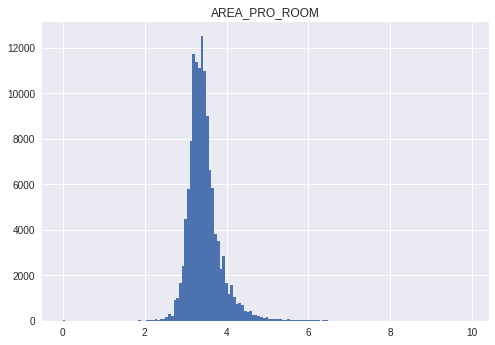

In [166]:
df.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd44e6cc0>]],
      dtype=object)

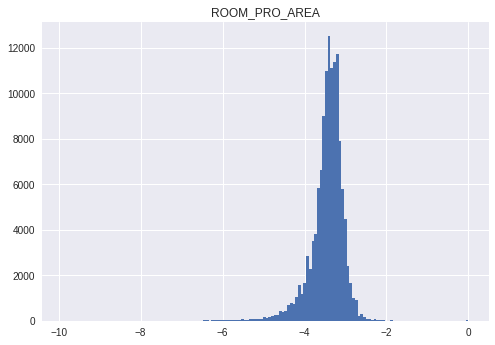

In [167]:
df.hist("ROOM_PRO_AREA", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dce8f4208>]],
      dtype=object)

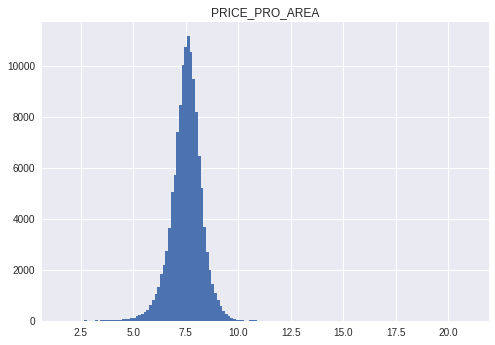

In [168]:
df.hist("PRICE_PRO_AREA", bins=BINS)

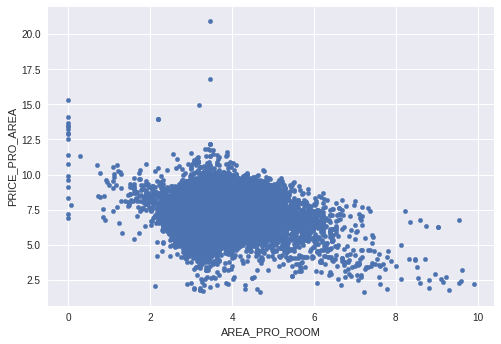

In [169]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

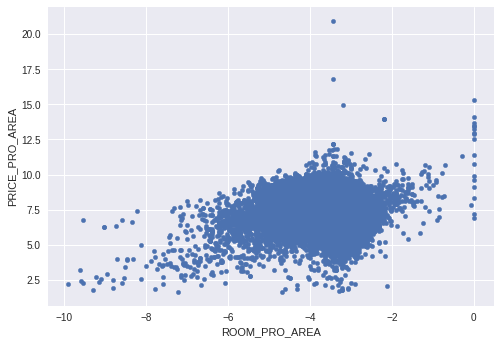

In [170]:
df.plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [0]:
def make_dataset_and_labels_and_class_num(df, label_name):
  """This method will prepare da, labels for train, evaluation, test.
     Args:
      df: DataFrame format of datasource.
      label_name: The name of column in datasource which will be as target for train.
     Return: 
       Tuple of (ds_train, ds_eval, ds_test, label_train, label_eval, label_test)
      
  """
  target_label_col = label_name
   
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  label_train = ds_train[[target_label_col]]
  
  ds_rest = df.drop(ds_train.index)
  ds_rest = ds_rest.copy()
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  label_eval = ds_eval[[target_label_col]]
  
  ds_test = ds_rest.drop(ds_eval.index)
  label_test = ds_test[[target_label_col]]
  
  return ds_train[["AREA_PRO_ROOM", "ROOM_PRO_AREA"]], ds_eval[["AREA_PRO_ROOM", "ROOM_PRO_AREA"]], ds_test[["AREA_PRO_ROOM", "ROOM_PRO_AREA"]], label_train, label_eval, label_test

In [0]:
x_train, x_eval, x_test, y_train, y_eval, y_test = make_dataset_and_labels_and_class_num(df, "PRICE_PRO_AREA")

In [173]:
x_train.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,89726.000000,89726.000000
mean,3.452555,-3.452555
std,0.428083,0.428083
min,0.000000,-9.903488
25%,3.218876,-3.605498
50%,3.395626,-3.395626
75%,3.605498,-3.218876
max,9.903488,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd48a9390>]],
      dtype=object)

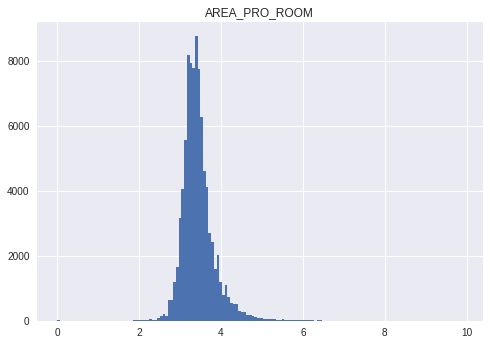

In [174]:
x_train.hist("AREA_PRO_ROOM", bins = BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd467ccc0>]],
      dtype=object)

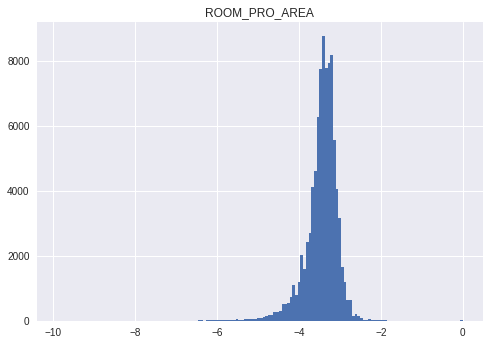

In [175]:
x_train.hist("ROOM_PRO_AREA", bins = BINS)

In [176]:
y_train.describe()

,PRICE_PRO_AREA
count,89726.000000
mean,7.524564
std,0.733832
min,1.666556
25%,7.130899
50%,7.563631
75%,7.962196
max,20.960654


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd454a630>]],
      dtype=object)

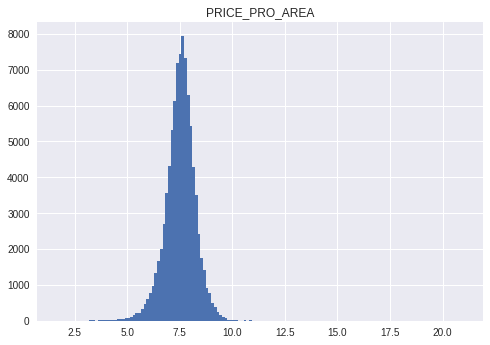

In [177]:
y_train.hist("PRICE_PRO_AREA", bins=BINS)

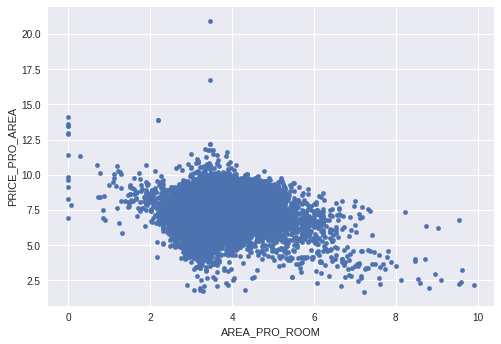

In [178]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA') 

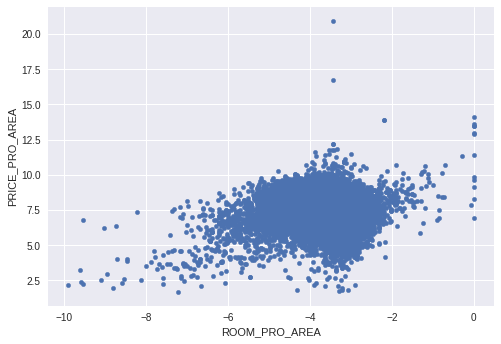

In [179]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA') 

In [180]:
x_eval.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,26918.000000,26918.000000
mean,3.452447,-3.452447
std,0.427896,0.427896
min,0.000000,-9.305651
25%,3.218876,-3.601868
50%,3.392829,-3.392829
75%,3.601868,-3.218876
max,9.305651,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dce785160>]],
      dtype=object)

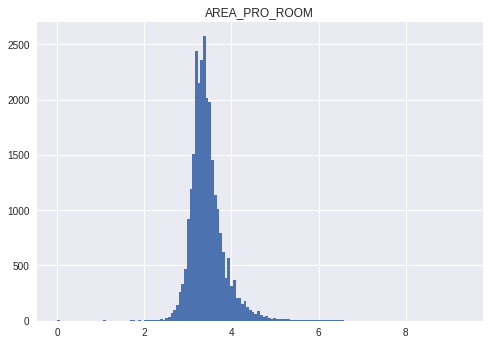

In [181]:
x_eval.hist("AREA_PRO_ROOM", bins = BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd3da77f0>]],
      dtype=object)

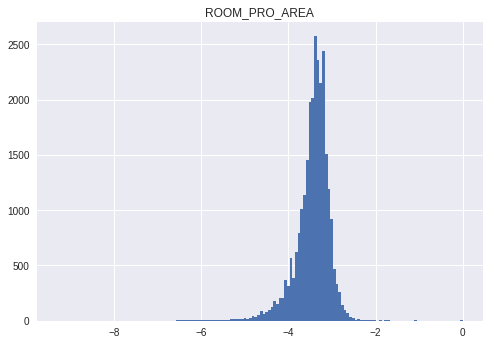

In [182]:
x_eval.hist("ROOM_PRO_AREA", bins = BINS)

In [183]:
y_eval.describe()

,PRICE_PRO_AREA
count,26918.000000
mean,7.524095
std,0.736682
min,1.776492
25%,7.130899
50%,7.559609
75%,7.972812
max,13.920871


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4df78800f0>]],
      dtype=object)

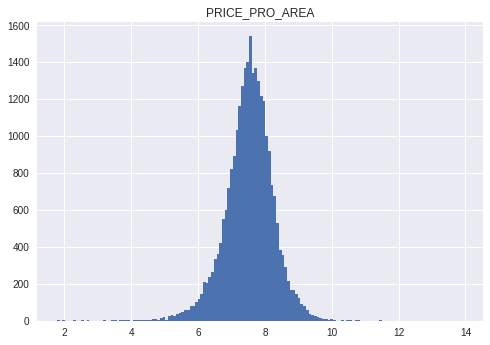

In [184]:
y_eval.hist("PRICE_PRO_AREA", bins=BINS)

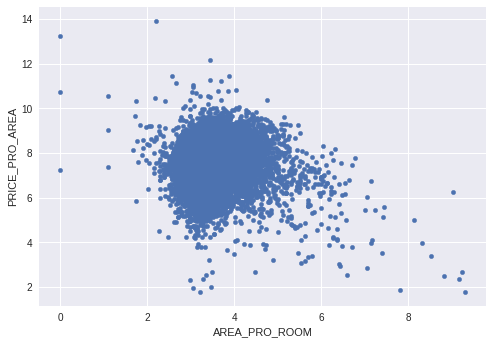

In [185]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

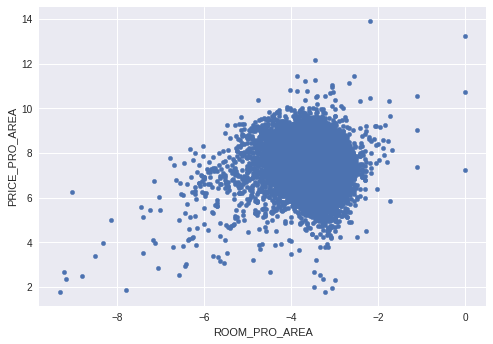

In [186]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [187]:
x_test.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,11536.000000,11536.000000
mean,3.448148,-3.448148
std,0.410921,0.410921
min,0.000000,-8.594154
25%,3.218876,-3.601868
50%,3.394508,-3.394508
75%,3.601868,-3.218876
max,8.594154,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd3a65cc0>]],
      dtype=object)

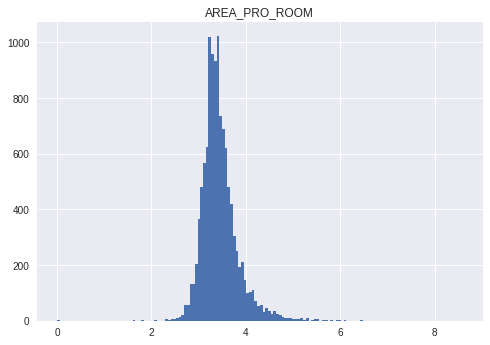

In [188]:
x_test.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd15653c8>]],
      dtype=object)

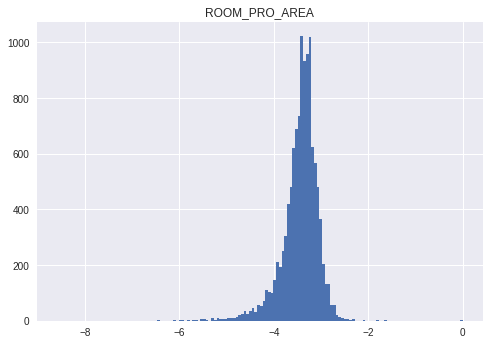

In [189]:
x_test.hist("ROOM_PRO_AREA", bins=BINS)

In [190]:
y_test.describe()

,PRICE_PRO_AREA
count,11536.000000
mean,7.520608
std,0.728791
min,1.629641
25%,7.130899
50%,7.555400
75%,7.956767
max,15.274126


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd3b37f28>]],
      dtype=object)

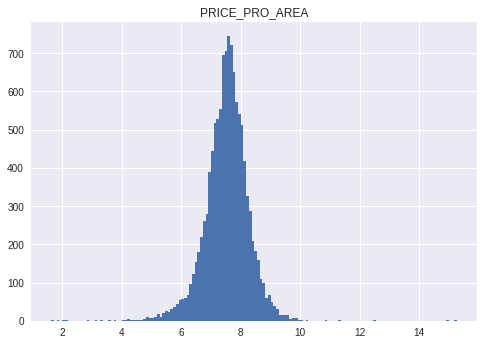

In [191]:
y_test.hist("PRICE_PRO_AREA", bins=BINS)

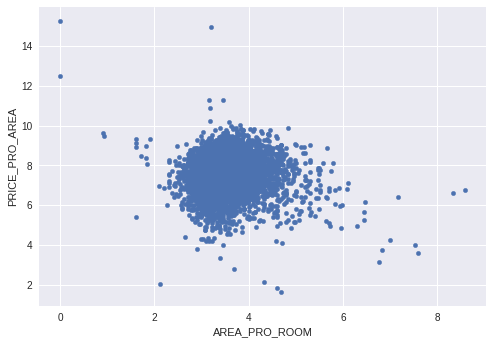

In [192]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

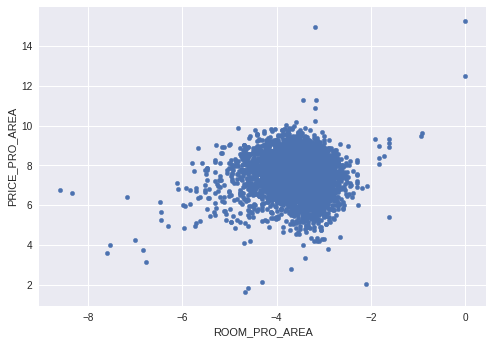

In [193]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [194]:
x_train.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA
18511,3.871201,-3.871201
83096,2.995732,-2.995732
113204,3.044522,-3.044522
101665,3.401197,-3.401197
88123,3.912023,-3.912023


In [195]:
x_eval.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA
50206,3.912023,-3.912023
153113,3.871201,-3.871201
110393,3.526361,-3.526361
202521,3.068053,-3.068053
143404,2.833213,-2.833213


In [196]:
x_test.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA
5,3.332205,-3.332205
51,3.218876,-3.218876
80,3.149883,-3.149883
105,2.944439,-2.944439
134,3.555348,-3.555348


In [197]:
y_train.head()

,PRICE_PRO_AREA
18511,8.481854
83096,7.090077
113204,7.624433
101665,6.674140
88123,7.590852


In [198]:
y_eval.head()

,PRICE_PRO_AREA
50206,7.130899
153113,8.706435
110393,7.428822
202521,7.731523
143404,7.293418


In [199]:
y_test.head()

,PRICE_PRO_AREA
5,7.666556
51,5.857933
80,7.539534
105,6.017440
134,9.456084


In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
 
    # Construct a dataset, and configure batching/repeating
    features = {key:np.array(value) for key,value in dict(features).items()} 
  
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
train_input_fn = lambda: input_fn(x_train, y_train)

In [0]:
train_predict_input_fn = lambda: input_fn(x_train, y_train, num_epochs=1, shuffle=False)

In [0]:
eval_predict_input_fn = lambda: input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

In [0]:
test_predict_input_fun = lambda: input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM"),
  tf.feature_column.numeric_column("ROOM_PRO_AREA") 
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [207]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8n4y8apg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4dda7a5518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [208]:
for period in range(0, PERIODS):
  model.train(input_fn=train_input_fn, steps=STEPS)
  #train_predict = model.predict(input_fn=train_predict_input_fn)
  #eval_predict = model.predict(input_fn=eval_predict_input_fn)
  print("-" * 100)
  metrics_train = model.evaluate(steps=STEPS, input_fn=train_predict_input_fn)
  metrics_eval = model.evaluate(steps=STEPS, input_fn=eval_predict_input_fn) 
  print("-" * 100)
  
  #train_predict = np.array([item['predictions'][0] for item in train_predict])
  #eval_predict = np.array([item['predictions'][0] for item in eval_predict])
  
  # Compute loss for train and evaluation
  #train_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(train_predict, y_train))
  #eval_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(eval_predict, y_eval))
  train_rmse = np.sqrt(metrics_train['average_loss'])
  eval_rmse = np.sqrt(metrics_eval['average_loss'])
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8n4y8apg/model.ckpt.
INFO:tensorflow:loss = 63.2881, step = 0
INFO:tensorflow:global_step/sec: 334.58
INFO:tensorflow:loss = 64.54947, step = 100 (0.304 sec)
INFO:tensorflow:global_step/sec: 373.549
INFO:tensorflow:loss = 63.373177, step = 200 (0.266 sec)
INFO:tensorflow:global_step/sec: 401.539
INFO:tensorflow:loss = 65.37683, step = 300 (0.249 sec)
INFO:tensorflow:global_step/sec: 415.112
INFO:tensorflow:loss = 72.34677, step = 400 (0.243 sec)
INFO:tensorflow:global_step/sec: 415.545
INFO:tensorflow:loss = 52.63026, step = 500 (0.237 sec)
INFO:tensorflow:global_step/sec: 410.032
INFO:tensorflow:loss = 45.648254, step = 600 (0.247 sec)
INFO:tensorflow:global_step/sec: 377.552
INFO:tensorflow:loss = 

In [209]:
test_predict = model.predict(input_fn=test_predict_input_fun)
print("-" * 100)
metrics_test = model.evaluate(steps=STEPS, input_fn=test_predict_input_fun)
print("-" * 100)
test_predict = np.array([item['predictions'][0] for item in test_predict])  
#test_rmse = math.sqrt(
#        sklearn.metrics.mean_squared_error(test_predict, y_test))
test_rmse = np.sqrt(metrics_test['average_loss'])
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

----------------------------------------------------------------------------------------------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-26-19:23:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8n4y8apg/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-08-26-19:23:45
INFO:tensorflow:Saving dict for global step 20000: average_loss = 49.37174, global_step = 20000, label/mean = 7.4891133, loss = 49.

In [0]:
test_predict = np.array([item for item in test_predict])

In [211]:
test_predict

array([0.48161405, 0.46592528, 0.45637417, ..., 0.48161405, 0.49570447,
       0.49116516], dtype=float32)